In [51]:
# ###############################################
# ########## Default Parameters #################
# ###############################################
start = '2016-06-17 00:00:00'
end = '2016-06-18 00:00:00'
pv_nominal_kw = 1000
inverter_sizing = 1.05
inverter_qmax_percentage = 0.44
thrP = 0.04
hysP = 0.06
thrQ = 0.03
hysQ = 0.03
# hold_time_const = 5 * 60
first_order_time_const = 60
solver_relative_tolerance = 0.01
solver_absolute_tolerance = 0.01
solver_name = 'CVode'
result_filename = 'result'

In [52]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
import numpy
import datetime
from tabulate import tabulate
import json
import re

# Imports useful for graphics
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("whitegrid")
seaborn.despine()
%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Date conversion
begin = '2016-01-01 00:00:00'
begin_dt = datetime.datetime.strptime(begin, '%Y-%m-%d %H:%M:%S')
start_dt = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
end_dt = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
start_s = int((start_dt - begin_dt).total_seconds())
end_s = int((end_dt - begin_dt).total_seconds())

In [53]:
inverter_smax = pv_nominal_kw * inverter_sizing
inverter_qmax = inverter_smax * inverter_qmax_percentage
pv_inverter_parameters = {
    'weather_file':("C:\\Users\\cyder\\Desktop\\fmi-for-power-system\\" +
        'tests\\014_pandapower_test_default\\pv_inverter\\' +
        'USA_CA_San.Francisco.Intl.AP.724940_TMY3.mos'),
    'n': 1,
    'A': (pv_nominal_kw * 1000) / (0.158 * 1000),
    'eta': 0.158,
    'lat': 37.9,
    'til': 10,
    'azi': 0,
    'thrP': thrP,  #0.05,
    'hysP': hysP,  #0.04,
    'thrQ': thrQ,  #0.04,
    'hysQ': hysQ,  #0.01,
    'SMax': inverter_smax,
    'QMaxInd': inverter_qmax,
    'QMaxCap': inverter_qmax,
#     'Ts': hold_time_const,
}

run_simulation = True
connections_filename = 'connections.xlsx'
pv_inverter_path = 'pv_inverter/Pv_Inv_VoltVarWatt_simple_Slim.fmu'
pandapower_path = 'pandapower/pandapower.fmu'
pandapower_folder = 'pandapower'
pandapower_parameter = {
    'Tfirstorder': first_order_time_const
}

# Run the network

In [54]:
import pandapower as pp
import pandapower.networks as pn
grid = pn.case33bw()
grid['ext_grid'].loc[0, 'vm_pu'] = 1.05      
pp.runpp(grid)
grid['res_bus'].head()

,vm_pu,va_degree,p_kw,q_kvar
0,1.050000,0.000000,-3896.199811,-2420.793376
1,1.047189,0.013029,100.000000,60.000000
10,0.982313,-0.168975,45.000000,30.000000
11,0.980897,-0.158750,60.000000,35.000000
12,0.975128,-0.240262,60.000000,35.000000


# Compile FMU

In [55]:
structure = pandas.DataFrame(columns=['name', 'description',
                                      'causality', 'start',
                                      'type', 'unit'])
# Open P, Q, V for each PV
node = 7
structure = structure.append(
    {'name': 'KW_' + str(node),
     'causality': 'input'},
    ignore_index=True)
structure = structure.append(
    {'name': 'KVAR_' + str(node),
     'causality': 'input'},
    ignore_index=True)
structure = structure.append(
    {'name': 'Vpu_' + str(node),
     'causality': 'output'},
    ignore_index=True)
structure = structure.append(
    {'name': 'Vpu_' + str(12),
     'causality': 'output'},
    ignore_index=True)


structure['start'] = [0] * len(structure)
structure['description'] = ['_'] * len(structure)
structure['type'] = ['Real'] * len(structure)
structure['unit'] = ['_'] * len(structure)

print(tabulate(structure.head(), headers='keys', tablefmt='psql'))
structure.to_excel('pandapower/pandapower.xlsx', index=False)

+----+--------+---------------+-------------+---------+--------+--------+
|    | name   | description   | causality   |   start | type   | unit   |
|----+--------+---------------+-------------+---------+--------+--------|
|  0 | KW_7   | _             | input       |       0 | Real   | _      |
|  1 | KVAR_7 | _             | input       |       0 | Real   | _      |
|  2 | Vpu_7  | _             | output      |       0 | Real   | _      |
|  3 | Vpu_12 | _             | output      |       0 | Real   | _      |
+----+--------+---------------+-------------+---------+--------+--------+


In [56]:
import shlex, subprocess
cmd = ("C:/JModelica.org-2.1/setenv.bat && " +
       " cd " + pandapower_folder + " && "
       "cyderc " +
       " --path ./"
       " --name pandapower" +
       " --io pandapower.xlsx" +
       " --fmu_struc python" +
       " --path_to_simulatortofmu C:/Users/cyder/Desktop/" +
       "SimulatorToFMU/simulatortofmu/parser/SimulatorToFMU.py")        
args = shlex.split(cmd)
process = subprocess.Popen(args, bufsize=1, universal_newlines=True)
process.wait()
process.kill()

## Create the connection mapping

In [57]:
connections = pandas.DataFrame(columns=['fmu1_id', 'fmu1_path',
                                      'fmu2_id', 'fmu2_path',
                                      'fmu1_parameters',
                                      'fmu2_parameters',
                                      'fmu1_output',
                                      'fmu2_input'])

# Connection for each customer
nodes = [7, 9, 24]
nodes = [7]
for index in nodes:
    connections = connections.append(
        {'fmu1_id': 'PV' + str(index),
         'fmu1_path': pv_inverter_path,
         'fmu2_id': 'pandapower',
         'fmu2_path': pandapower_path,
         'fmu1_parameters': pv_inverter_parameters,
         'fmu2_parameters': pandapower_parameter,
         'fmu1_output': 'P',
         'fmu2_input': 'KW_' + str(index)},
        ignore_index=True)
    connections = connections.append(
        {'fmu1_id': 'PV' + str(index),
         'fmu1_path': pv_inverter_path,
         'fmu2_id': 'pandapower',
         'fmu2_path': pandapower_path,
         'fmu1_parameters': pv_inverter_parameters,
         'fmu2_parameters': pandapower_parameter,
         'fmu1_output': 'Q',
         'fmu2_input': 'KVAR_' + str(index)},
        ignore_index=True)
    connections = connections.append(
        {'fmu1_id': 'pandapower',
         'fmu1_path': pandapower_path,
         'fmu2_id': 'PV' + str(index),
         'fmu2_path': pv_inverter_path,
         'fmu1_parameters': pandapower_parameter,
         'fmu2_parameters': pv_inverter_parameters,
         'fmu1_output': 'Vpu_' + str(index),
         'fmu2_input': 'v'},
        ignore_index=True)
    
def _sanitize_name(name):
    """
    Make a Modelica valid name.
    In Modelica, a variable name:
    Can contain any of the characters {a-z,A-Z,0-9,_}.
    Cannot start with a number.
    :param name(str): Variable name to be sanitized.
    :return: Sanitized variable name.
    """

    # Check if variable has a length > 0
    assert(len(name) > 0), 'Require a non-null variable name.'

    # If variable starts with a number add 'f_'.
    if(name[0].isdigit()):
        name = 'f_' + name

    # Replace all illegal characters with an underscore.
    g_rexBadIdChars = re.compile(r'[^a-zA-Z0-9_]')
    name = g_rexBadIdChars.sub('_', name)
    return name
connections['fmu1_output'] = connections['fmu1_output'].apply(lambda x: _sanitize_name(x))
connections['fmu2_input'] = connections['fmu2_input'].apply(lambda x: _sanitize_name(x))

print(tabulate(connections[
    ['fmu1_id', 'fmu2_id', 'fmu1_output', 'fmu2_input']].head(),
    headers='keys', tablefmt='psql'))
print(tabulate(connections[
    ['fmu1_id', 'fmu2_id', 'fmu1_output', 'fmu2_input']].tail(),
    headers='keys', tablefmt='psql'))
connections.to_excel(connections_filename, index=False)

+----+------------+------------+---------------+--------------+
|    | fmu1_id    | fmu2_id    | fmu1_output   | fmu2_input   |
|----+------------+------------+---------------+--------------|
|  0 | PV7        | pandapower | P             | KW_7         |
|  1 | PV7        | pandapower | Q             | KVAR_7       |
|  2 | pandapower | PV7        | Vpu_7         | v            |
+----+------------+------------+---------------+--------------+
+----+------------+------------+---------------+--------------+
|    | fmu1_id    | fmu2_id    | fmu1_output   | fmu2_input   |
|----+------------+------------+---------------+--------------|
|  0 | PV7        | pandapower | P             | KW_7         |
|  1 | PV7        | pandapower | Q             | KVAR_7       |
|  2 | pandapower | PV7        | Vpu_7         | v            |
+----+------------+------------+---------------+--------------+


# Launch FMU simulation

In [58]:
if run_simulation:
    import os
    import signal
    import shlex, subprocess
    cmd = ("C:/JModelica.org-2.1/setenv.bat && " +
           "cyders " +
           " --start " + str(start_s) +
           " --end " + str(end_s) +
           " --connections " + connections_filename +
           " --nb_steps 50" +
           " --solver " + solver_name +
           " --rtol " + str(solver_relative_tolerance) +
           " --atol " + str(solver_absolute_tolerance) +
           " --result " + 'results/' + result_filename + '.csv')        
    args = shlex.split(cmd)
    process = subprocess.Popen(args, bufsize=1, universal_newlines=True,
                              creationflags=subprocess.CREATE_NEW_PROCESS_GROUP)
    process.wait()
    process.send_signal(signal.CTRL_BREAK_EVENT)
    process.kill()
    print('Killed')

Killed


# Plot results

In [59]:
# Load results
results = pandas.read_csv('results/' + result_filename + '.csv')
epoch = datetime.datetime.utcfromtimestamp(0)
begin_since_epoch = (begin_dt - epoch).total_seconds()
results['datetime'] = results['time'].apply(
    lambda x: datetime.datetime.utcfromtimestamp(begin_since_epoch + x))
results.set_index('datetime', inplace=True, drop=False)
print('COLUMNS=')
print(results.columns)
print('START=')
print(results.head(1).index[0])
print('END=')
print(results.tail(1).index[0])

COLUMNS=
Index([u'time', u'PV7.A', u'PV7.P', u'PV7.Q', u'PV7.QMaxCap', u'PV7.QMaxInd',
       u'PV7.SMax', u'PV7.S_curtail_P.y', u'PV7.Tfirstorder', u'PV7.WtokW.k',
       ...
       u'pandapower.der(Vpu_7_transfer.y)', u'pandapower.nDblInp',
       u'pandapower.nDblOut', u'pandapower.nDblPar', u'pandapower.nStrPar',
       u'pandapower.passMemoryObject', u'pandapower.uR[1]',
       u'pandapower.uR[2]', u'time.1', u'datetime'],
      dtype='object', length=718)
START=
2016-06-17 00:00:00
END=
2016-06-18 00:00:00


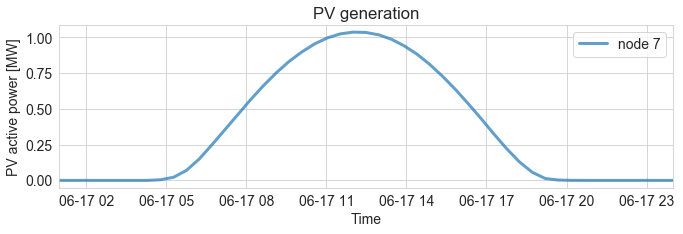

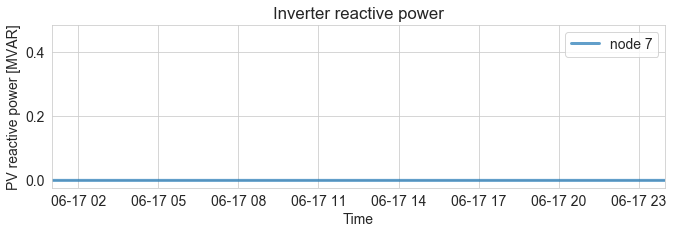

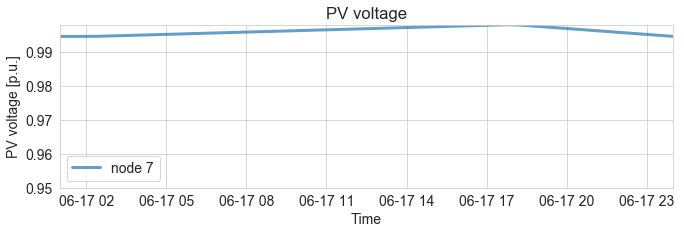

In [60]:
# Plot sum of all PVs for P and P curtailled and Q
cut = '2016-06-17 01:00:00'
fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('PV generation')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.KW_' + str(node)] / 1000,
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV active power [MW]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('Inverter reactive power')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.KVAR_' + str(node)] / 1000,
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV reactive power [MVAR]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.title('PV voltage')
for node in nodes:
    plt.plot(results['datetime'],
             results['pandapower.Vpu_' + str(node)],
            linewidth=3, alpha=0.7, label='node ' + str(node))
plt.legend(loc=0)
plt.ylabel('PV voltage [p.u.]')
plt.xlabel('Time')
plt.xlim([cut, end])
plt.ylim([0.95, results[['pandapower.Vpu_' + str(node)
                         for node in nodes]].max().max()])
plt.show()

In [61]:
# Load results
debug = pandas.read_csv('debug.csv', parse_dates=[1])
epoch = datetime.datetime.utcfromtimestamp(0)
begin_since_epoch = (begin_dt - epoch).total_seconds()
debug['datetime'] = debug['sim_time'].apply(
    lambda x: datetime.datetime.utcfromtimestamp(begin_since_epoch + x))
debug.set_index('datetime', inplace=True, drop=False)
print('COLUMNS=')
print(debug.columns)
print('START=')
print(debug.head(1).index[0])
print('END=')
print(debug.tail(1).index[0])

COLUMNS=
Index([u'sim_time', u'clock', u'KW_7', u'KVAR_7', u'Vpu_7', u'Vpu_12',
       u'datetime'],
      dtype='object')
START=
2016-06-17 00:00:00
END=
2016-06-18 00:00:00


Number of evaluation=678


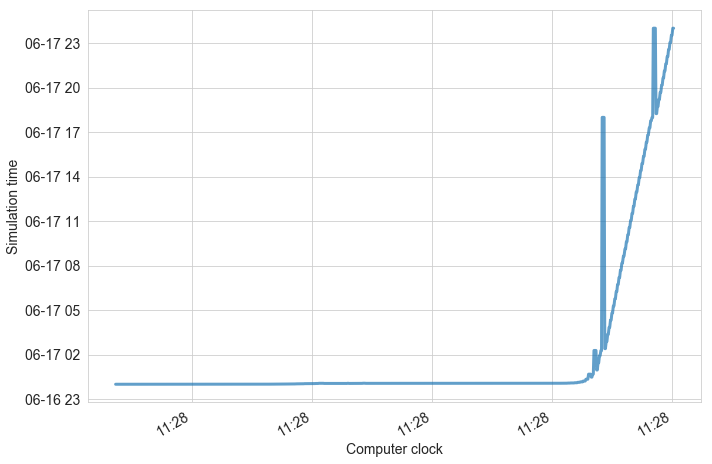

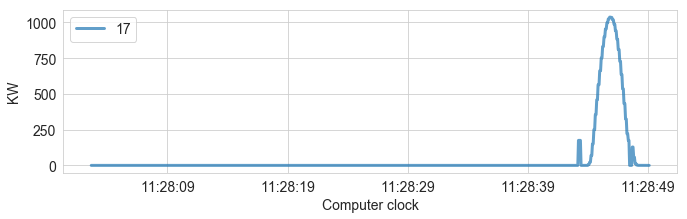

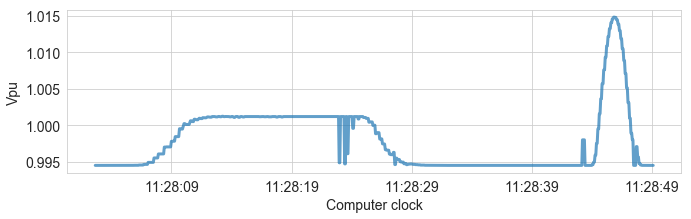

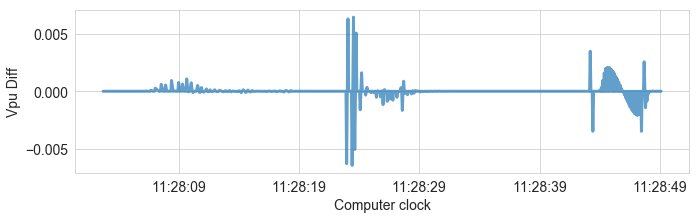

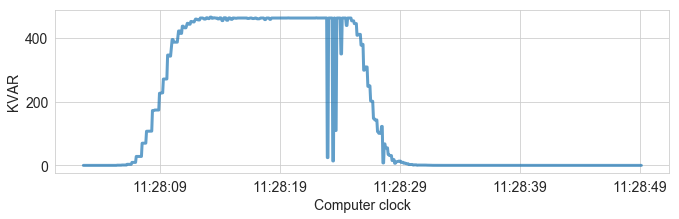

In [64]:
# Plot time/voltage
import matplotlib.dates as mdates
print('Number of evaluation=' + str(len(debug)))
fig, axes = plt.subplots(1, 1, figsize=(11, 8))
plt.plot(debug['clock'],
         debug['datetime'],
        linewidth=3, alpha=0.7)
plt.ylabel('Simulation time')
plt.xlabel('Computer clock')
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.plot(debug['clock'],
         debug['KW_7'],
        linewidth=3, alpha=0.7)
plt.ylabel('KW')
plt.xlabel('Computer clock')
plt.legend([17, 31, 24], loc=0)
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.plot(debug['clock'],
         debug['Vpu_7'],
        linewidth=3, alpha=0.7)
plt.ylabel('Vpu')
plt.xlabel('Computer clock')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.plot(debug['clock'],
         debug['Vpu_7'].diff(),
        linewidth=3, alpha=0.7)
plt.ylabel('Vpu Diff')
plt.xlabel('Computer clock')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(11, 3))
plt.plot(debug['clock'],
         debug['KVAR_7'],
        linewidth=3, alpha=0.7)
plt.ylabel('KVAR')
plt.xlabel('Computer clock')
plt.show()